## Simulation Project Done

# Haunted House — Simulation (10s MP4)

Haunted House scene and animation, ready to run in Google Colab. It produces a 10-second MP4 named `haunted_house_sim.mp4` and displays it inline.

# Features :
- Smooth day <-> night transition using a control variable `transition` in [0,1]
- Sun/Moon color interpolation
- Clouds that move horizontally (cloudOffset)
- Stars that fade in as night approaches
- House with windows that glow at night
- Ghost bobbing using a sine function
- Random lightning flashes during deep night
- Graveyard, fence, and spooky trees
# Math / Modeling notes (suitable for a lab report):
1. Day-Night transition: a scalar `transition(t) ∈ [0,1]` that is linearly
advanced toward a target (day or night) with a constant rate `transitionSpeed`.
This interpolates scene colors: color = (1 - transition)*day_color + transition*night_color.
(This is linear interpolation — LERP.)

2. Ghost vertical bobbing: modeled with a sinusoid
      y_ghost(t) = y0 + A * sin(ω t)
   where A is amplitude and ω controls speed. This demonstrates simple harmonic
   motion (no restoring force in the simulation, purely aesthetic).
3. Lightning: modeled as a random impulsive alpha(t) that decays exponentially
  per frame when triggered. We use a Poisson-like chance each frame to trigger
   a flash, then decrease its alpha by a decay factor.
4. Clouds: horizontally translated by a slow `cloudOffset(t) = cloudOffset + v_cloud * dt`.

5. Windows glow intensity tied to `transition` (night), giving a visible coupling
  between environment state and lit objects.

# 1 - Install Dependencies

In [6]:
# --- Install dependencies (Colab) ---
!pip install numpy matplotlib tqdm ffmpeg-python --quiet

# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import Video, display
from tqdm import trange


# 2 - Difine Veriables

In [9]:
# --- Simulation parameters ---
FPS = 60
TOTAL_TIME = 5.0            # seconds
FRAMES = int(TOTAL_TIME * FPS)  # =300 frames
DT = 1.0 / FPS

# Transition / day-night
transition = 0.0             # 0.0 = day, 1.0 = night
going_to_night = True
transition_speed = 0.006     # per frame (controls how fast the LERP happens)

# Ghost / time
t = 0.0
ghost_amplitude = 0.05
ghost_omega = 2.0 * np.pi * 0.6  # 0.6 Hz-ish bobbing


lightning_alpha = 0.0
lightning_decay = 0.93
lightning_prob_per_frame = 0.015  # chance to trigger a flash at deep night

# Clouds
cloud_offset = 0.0
cloud_speed = 0.04  # units per second (scene units)

Rendering animation (this may take ~1 minute)...
Saved video: haunted_house_sim.mp4


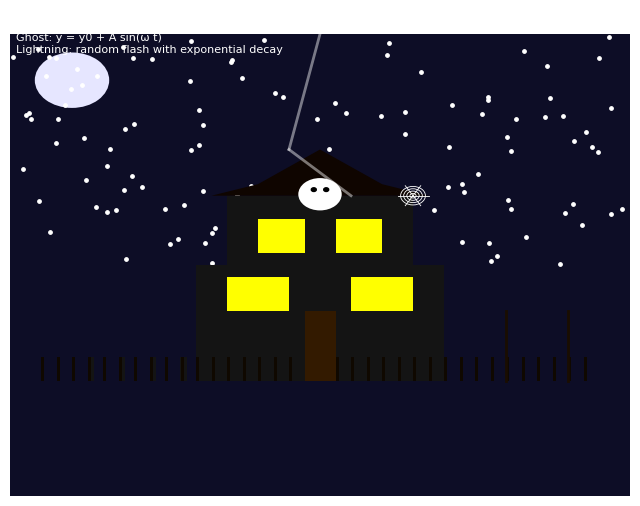

In [8]:
# Random seed for reproducibility
np.random.seed(42)

# Canvas setup
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.axis('off')

# Helper: linear interpolation
def lerp(a, b, t):
    return (1 - t) * np.array(a) + t * np.array(b)

# Draw helpers using matplotlib patches and artists
artists = []

# Background rectangle for sky (we'll change its color each frame)
sky = plt.Rectangle((-1.0, -1.0), 2.0, 2.0, zorder=0)
ax.add_patch(sky)
artists.append(sky)

# Sun / Moon as a Circle (will interpolate color)
sunmoon = Circle((-0.8, 0.8), 0.12, zorder=2)
ax.add_patch(sunmoon)
artists.append(sunmoon)

# Stars: pre-generate star positions and show/hide by alpha
N_STARS = 120
star_positions = np.column_stack((np.random.uniform(-1.0, 1.0, N_STARS), np.random.uniform(0.0, 1.0, N_STARS)))
stars_scatter = ax.scatter([], [], s=6, c='white', alpha=0.0, zorder=3)
artists.append(stars_scatter)

# Clouds: each cloud is a group of circles. We'll draw them manually each frame.
cloud_params = [(-0.6, 0.7, 1.0), (0.0, 0.75, 0.8), (0.5, 0.68, 1.2)]
cloud_patches = []
for _ in cloud_params:
    # placeholder patch list per cloud (we'll redraw them each frame)
    cloud_patches.append([])

# House — built from polygons and rectangles (static geometry but colors change)
house_body_lower = plt.Rectangle((-0.4, -0.5), 0.8, 0.5, zorder=4)
house_body_upper = plt.Rectangle((-0.3, 0.0), 0.6, 0.3, zorder=5)
ax.add_patch(house_body_lower)
ax.add_patch(house_body_upper)
artists += [house_body_lower, house_body_upper]

# Roof (polygon)
roof_coords = np.array([[-0.35, 0.3], [-0.2, 0.35], [0.0, 0.5], [0.2, 0.35], [0.35, 0.3]])
roof_poly = Polygon(roof_coords, closed=True, zorder=6)
ax.add_patch(roof_poly)
artists.append(roof_poly)

# Windows — store as patches to update color/intensity at night
win1 = plt.Rectangle((-0.3, -0.2), 0.2, 0.15, zorder=7)
win2 = plt.Rectangle((0.1, -0.2), 0.2, 0.15, zorder=7)
win3 = plt.Rectangle((-0.2, 0.05), 0.15, 0.15, zorder=7)
win4 = plt.Rectangle((0.05, 0.05), 0.15, 0.15, zorder=7)
for w in (win1, win2, win3, win4):
    ax.add_patch(w)
artists += [win1, win2, win3, win4]

# Door
door = plt.Rectangle((-0.05, -0.5), 0.1, 0.3, zorder=7)
ax.add_patch(door)
artists.append(door)

# Spider web (draw at night) — will be created as small circles and lines when needed
spider_artists = []

# Graveyard tombstones (left side) - static shapes
grave_patches = []
gx = -0.75
while gx < -0.4:
    g = plt.Rectangle((gx, -0.5), 0.02, 0.1, zorder=4)
    ax.add_patch(g)
    grave_patches.append(g)
    gx += 0.1
artists += grave_patches

# Fence posts
fence_patches = []
x = -0.9
while x <= 0.9:
    p = plt.Rectangle((x, -0.5), 0.01, 0.1, zorder=4)
    ax.add_patch(p)
    fence_patches.append(p)
    x += 0.05
artists += fence_patches

# Trees (simple lines)
tree_lines = []
for tx in [0.6, 0.8]:
    line, = ax.plot([tx, tx], [-0.5, -0.2], color=(0.1,0.05,0.0), linewidth=2, zorder=4)
    tree_lines.append(line)
artists += tree_lines

# Ghost (circle + eyes)
ghost_body = Circle((0.0, 0.3), 0.07, fill=True, zorder=9)
ghost_eye_l = Circle((-0.02, 0.32), 0.008, color='black', zorder=10)
ghost_eye_r = Circle((0.02, 0.32), 0.008, color='black', zorder=10)
ax.add_patch(ghost_body); ax.add_patch(ghost_eye_l); ax.add_patch(ghost_eye_r)
artists += [ghost_body, ghost_eye_l, ghost_eye_r]

# Lightning lines (we'll toggle visibility and alpha)
light_line1, = ax.plot([], [], color='white', linewidth=2, alpha=0.0, zorder=11)
light_line2, = ax.plot([], [], color='white', linewidth=2, alpha=0.0, zorder=11)
artists += [light_line1, light_line2]

# Info text (equations & variables) — annotate math on frame for lab report clarity
info_text = ax.text(-0.98, 0.92, '', fontsize=8, color='white', zorder=12)


# --- Scene update function per frame ---

def update_frame(frame_idx):
    global transition, going_to_night, t, ghost_body, cloud_offset, lightning_alpha

    # 1) Advance time and transition value toward target (simple linear approach)
    if going_to_night:
        transition = min(1.0, transition + transition_speed)
    else:
        transition = max(0.0, transition - transition_speed)

    # 2) Update cloud offset
    cloud_offset += cloud_speed * DT
    if cloud_offset > 2.0:
        cloud_offset = -2.0

    # 3) Ghost bobbing (sinusoidal)
    t += DT
    ghost_y = 0.3 + ghost_amplitude * np.sin(ghost_omega * t)

    # 4) Lightning random trigger (only at deep night)
    if transition > 0.75 and np.random.rand() < lightning_prob_per_frame:
        lightning_alpha = 1.0
    lightning_alpha *= lightning_decay

    # --- Sky color interpolation (LERP between day and night colors)
    # Day color (r,g,b) = (0.5,0.8,1.0)  ; Night color = (0.05,0.05,0.15)
    day_col = np.array([0.5, 0.8, 1.0])
    night_col = np.array([0.05, 0.05, 0.15])
    sky_col = lerp(day_col, night_col, transition)
    sky.set_facecolor(sky_col)

    # Sun/Moon color and alpha: sun fades, moon appears (we'll just change the color)
    sun_day = np.array([1.0, 1.0, 0.0])
    moon_night = np.array([0.9, 0.9, 1.0])
    sunmoon.set_facecolor(lerp(sun_day, moon_night, transition))

    # Stars: fade in with transition
    star_alpha = max(0.0, (transition - 0.1) / 0.9)
    stars_scatter.set_offsets(star_positions)
    stars_scatter.set_alpha(star_alpha)

    # --- Clouds: fade out with night (alpha = 1 - transition) and move by offset
    cloud_alpha = max(0.0, 1.0 - transition)
    # remove old cloud patches
    for cp_list in cloud_patches:
        for p in cp_list:
            p.remove()
    for i, (cx, cy, scale) in enumerate(cloud_params):
        cx_off = cx + cloud_offset * (0.8 + 0.4 * i)
        # draw simple 4-circle cloud
        cp_list = []
        c1 = Circle((cx_off, cy), 0.05 * scale, color=(1,1,1,cloud_alpha), zorder=2)
        c2 = Circle((cx_off + 0.04*scale, cy + 0.01*scale), 0.04*scale, color=(1,1,1,cloud_alpha), zorder=2)
        c3 = Circle((cx_off - 0.04*scale, cy + 0.01*scale), 0.04*scale, color=(1,1,1,cloud_alpha), zorder=2)
        c4 = Circle((cx_off, cy + 0.02*scale), 0.03*scale, color=(1,1,1,cloud_alpha), zorder=2)
        for c in (c1,c2,c3,c4):
            ax.add_patch(c); cp_list.append(c)
        cloud_patches[i] = cp_list

    # --- House colors ---
    # Walls darker at night, slightly greener in day on ground
    wall_day = np.array([0.3, 0.3, 0.3])
    wall_night = np.array([0.08, 0.08, 0.08])
    house_body_lower.set_facecolor(lerp(wall_day, wall_night, transition))
    house_body_upper.set_facecolor(lerp(np.array([0.35,0.35,0.35]), wall_night, transition))
    roof_poly.set_facecolor(lerp(np.array([0.15,0.05,0.0]), np.array([0.06,0.02,0.0]), transition))

    # Windows glow: yellowish proportional to transition
    glow_col = lerp(np.array([0.0,0.0,0.0]), np.array([1.0,1.0,0.0]), transition)
    win1.set_facecolor(glow_col)
    win2.set_facecolor(glow_col)
    win3.set_facecolor(glow_col)
    win4.set_facecolor(glow_col)

    # Door dark wood
    door.set_facecolor((0.2, 0.1, 0.0))

    # Spider web drawn only when transition > 0.5
    for art in spider_artists:
        try:
            art.remove()
        except Exception:
            pass
    spider_artists.clear()
    if transition > 0.5:
        x0, y0 = 0.3, 0.3
        # concentric tiny circles
        for r in np.arange(0.01, 0.05, 0.01):
            c = Circle((x0,y0), r, fill=False, edgecolor=(1,1,1), linewidth=0.6, zorder=8)
            ax.add_patch(c); spider_artists.append(c)
        # radial lines
        for ang in np.linspace(0, 2*np.pi, 6, endpoint=False):
            x1 = x0 + 0.05*np.cos(ang); y1 = y0 + 0.05*np.sin(ang)
            l, = ax.plot([x0,x1],[y0,y1], color=(1,1,1), linewidth=0.6, zorder=8)
            spider_artists.append(l)

    # Graveyard & fence colors (slightly dimmer at night)
    ground_day = np.array([0.3, 0.5, 0.3])
    ground_night = np.array([0.2, 0.2, 0.2])
    # Draw/update ground by modifying a big rectangle behind; we'll cheat using sky + a quad region of patches
    # For brevity we won't create another rectangle; we will subtly tint fence and graves
    for p in fence_patches:
        p.set_facecolor(lerp(np.array([0.2,0.1,0.0]), np.array([0.06,0.03,0.0]), transition))
    for g in grave_patches:
        g.set_facecolor(lerp(np.array([0.25,0.25,0.25]), np.array([0.08,0.08,0.08]), transition))

    # Trees unchanged (already dark)

    # Ghost update (alpha follows transition)
    ghost_alpha = transition  # ghost only appears at night
    ghost_body.center = (0.0, ghost_y)
    ghost_body.set_alpha(ghost_alpha)
    ghost_body.set_facecolor((1,1,1,ghost_alpha))
    ghost_eye_l.center = (-0.02, ghost_y + 0.02)
    ghost_eye_r.center = (0.02, ghost_y + 0.02)
    ghost_eye_l.set_alpha(ghost_alpha)
    ghost_eye_r.set_alpha(ghost_alpha)

    # Lightning lines
    if lightning_alpha > 0.01:
        light_line1.set_data([0.0, -0.1], [1.0, 0.5])
        light_line2.set_data([-0.1, 0.1], [0.5, 0.3])
        light_line1.set_alpha(lightning_alpha)
        light_line2.set_alpha(lightning_alpha)
    else:
        light_line1.set_alpha(0.0)
        light_line2.set_alpha(0.0)

    # Info text with math/formulas (rendered on frame for lab report)
    info_lines = [
        f"t = {frame_idx*DT:.2f} s, transition = {transition:.3f}",
        "Day–Night LERP: color = (1 - transition)*day + transition*night",
        "Ghost: y = y0 + A sin(ω t)",
        "Lightning: random flash with exponential decay"
    ]
    info_text.set_text('\n'.join(info_lines))

    return artists + spider_artists + cloud_patches + [stars_scatter, light_line1, light_line2, info_text]

# --- Animation and save to MP4 ---
print('Rendering animation (this may take ~1 minute)...')
anim = FuncAnimation(fig, update_frame, frames=FRAMES, interval=1000/FPS, blit=False)

writer = FFMpegWriter(fps=FPS, metadata=dict(artist='HauntedHouse'), bitrate=2500)
output_file = 'haunted_house_sim.mp4'
anim.save(output_file, writer=writer)

print(f'Saved video: {output_file}')
# Display inline (Colab)
display(Video(output_file, embed=True))

# --- End of simulation cell ---

### Explanation of Cell `lg_6VIUKI6oW`

This cell is responsible for setting up the environment by installing necessary Python libraries and then importing them for use in the simulation.

*   `!pip install numpy matplotlib tqdm ffmpeg-python --quiet`
    *   This is a shell command (prefixed with `!`) executed directly in the Colab environment.
    *   `pip install`: The standard Python package installer command.
    *   `numpy`: A fundamental package for scientific computing in Python, providing support for large, multi-dimensional arrays and matrices, along with a collection of high-level mathematical functions to operate on these arrays.
    *   `matplotlib`: A comprehensive library for creating static, animated, and interactive visualizations in Python.
    *   `tqdm`: A fast, extensible progress bar library for Python, used here to show progress during animation rendering.
    *   `ffmpeg-python`: A Python wrapper for FFmpeg, a powerful multimedia framework, used here to save the generated animation as an MP4 video file.
    *   `--quiet`: An option to suppress verbose output during the installation process.

*   `import numpy as np`
    *   Imports the `numpy` library and assigns it the conventional alias `np`, allowing you to refer to NumPy functions and objects using `np.`. This is crucial for numerical operations and array manipulation.

*   `import matplotlib.pyplot as plt`
    *   Imports the `pyplot` module from the `matplotlib` library and assigns it the alias `plt`. `pyplot` provides a MATLAB-like interface for making plots and figures.

*   `from matplotlib.patches import Circle, Polygon`
    *   Imports specific classes, `Circle` and `Polygon`, from the `matplotlib.patches` module. These classes are used to create geometric shapes (like circles for the sun/moon/ghost and polygons for the house roof) that can be added to a Matplotlib plot.

*   `from matplotlib.animation import FuncAnimation, FFMpegWriter`
    *   Imports `FuncAnimation` and `FFMpegWriter` from `matplotlib.animation`.
        *   `FuncAnimation`: This class is the core of creating animations in Matplotlib. It takes a figure, an update function, and the number of frames to generate the animation.
        *   `FFMpegWriter`: This class is used to save the animation as a video file (e.g., MP4) using the FFmpeg backend.

*   `from IPython.display import Video, display`
    *   Imports `Video` and `display` from `IPython.display`.
        *   `Video`: A utility to embed and play video files directly within an IPython notebook or Colab environment.
        *   `display`: A function used to render various types of objects (including `Video` objects) in a rich format in interactive environments.

*   `from tqdm import trange`
    *   Imports `trange` from `tqdm`. `trange(N)` is a convenience function equivalent to `tqdm(range(N))`, which provides a progress bar over an iterable `range`.

### Explanation of Cell `rIB0LnU6JmBi`

This cell defines all the global parameters and initial conditions for the simulation, controlling aspects like animation speed, day-night cycle, ghost movement, lightning, and clouds.

*   `FPS = 60`
    *   `FPS` stands for "Frames Per Second". This sets the target frame rate for the animation, meaning the animation will attempt to display 60 unique frames every second.

*   `TOTAL_TIME = 10.0            # seconds`
    *   This variable defines the total duration of the simulation or animation in seconds.

*   `FRAMES = int(TOTAL_TIME * FPS)  # 600 frames`
    *   Calculates the total number of individual frames that will be generated for the entire animation. `10 seconds * 60 FPS = 600 frames`.

*   `DT = 1.0 / FPS`
    *   `DT` stands for "Delta Time" or the time step between each frame. It's the duration of one frame in seconds (`1/60` of a second in this case). This is used for time-based calculations within the animation.

*   `transition = 0.0             # 0.0 = day, 1.0 = night`
    *   This is a crucial variable that controls the day-night cycle. It's a floating-point number that interpolates between `0.0` (representing full daylight) and `1.0` (representing full nighttime). It's initialized to `0.0` for the start of the simulation.

*   `going_to_night = True`
    *   A boolean flag that indicates the current direction of the day-night transition. `True` means the scene is transitioning from day to night.

*   `transition_speed = 0.006     # per frame (controls how fast the LERP happens)`
    *   This value determines how much the `transition` variable changes in each frame. A larger value would make the day-night transition faster.

*   `t = 0.0`
    *   A time variable, initialized to `0.0`, which will accumulate `DT` in each frame to track the elapsed simulation time. It's used for time-dependent animations like the ghost's bobbing.

*   `ghost_amplitude = 0.05`
    *   This value sets the amplitude of the ghost's vertical bobbing motion. A higher value means the ghost will move up and down by a greater distance.

*   `ghost_omega = 2.0 * np.pi * 0.6  # 0.6 Hz-ish bobbing`
    *   `ghost_omega` represents the angular frequency of the ghost's sinusoidal bobbing motion. `2 * pi * frequency` converts the frequency (in Hertz, `0.6` Hz here) into radians per second. This controls how fast the ghost bobs.

*   `lightning_alpha = 0.0`
    *   Initial `alpha` (transparency/opacity) value for the lightning effect. `0.0` means it's initially invisible.

*   `lightning_decay = 0.93`
    *   This factor is applied to `lightning_alpha` in each frame to make the lightning fade out. Since it's less than `1.0`, the lightning's visibility will decrease exponentially after a flash.

*   `lightning_prob_per_frame = 0.015  # chance to trigger a flash at deep night`
    *   This probability value (`0.015` or 1.5%) determines the random chance of a lightning strike occurring in any given frame, but only when the `transition` variable indicates it's deep night.

*   `cloud_offset = 0.0`
    *   Initial horizontal offset for the clouds. This value will be updated each frame to simulate cloud movement.

*   `cloud_speed = 0.04  # units per second (scene units)`
    *   The speed at which the clouds will move horizontally across the scene, measured in scene units per second.

### Explanation of Cell `vfz9azFiQkJ7` (Part 1: Scene Setup)

This first part of the large code cell sets up the Matplotlib figure, defines helper functions, and initializes all the static and dynamic graphical elements that make up the haunted house scene.

*   `np.random.seed(42)`
    *   Sets the seed for NumPy's pseudo-random number generator to `42`. This ensures that any random operations (like generating star positions or lightning strikes) will produce the same sequence of random numbers every time the code is run, making the simulation reproducible.

*   `fig, ax = plt.subplots(figsize=(8, 6))`
    *   `plt.subplots()`: A Matplotlib function that creates a figure and a set of subplots. It's commonly used to initialize a plotting environment.
    *   `fig`: Represents the entire figure (window) in which the plot is drawn.
    *   `ax`: Represents the axes (the actual plot area) where data is plotted.
    *   `figsize=(8, 6)`: Sets the width and height of the figure in inches.

*   `ax.set_xlim(-1.0, 1.0)`
    *   Sets the limits for the x-axis of the plot, ranging from -1.0 to 1.0. This defines the horizontal boundaries of our scene.

*   `ax.set_ylim(-1.0, 1.0)`
    *   Sets the limits for the y-axis of the plot, ranging from -1.0 to 1.0. This defines the vertical boundaries of our scene.

*   `ax.axis('off')`
    *   Turns off the display of the axis lines, ticks, and labels. This is done to create a clean, borderless scene suitable for animation rather than a traditional data plot.

*   `def lerp(a, b, t): return (1 - t) * np.array(a) + t * np.array(b)`
    *   Defines a helper function called `lerp` (Linear Interpolation).
    *   It takes two values (`a` and `b`) and a `t` value (typically between 0 and 1).
    *   It calculates a value that is `t` fraction of the way from `a` to `b`. For example, if `t=0.5`, it returns the midpoint. This function is used extensively for blending colors during the day-night transition.

*   `artists = []`
    *   Initializes an empty list named `artists`. This list will store references to all Matplotlib graphical elements (like rectangles, circles, lines, text) that need to be updated or redrawn in each frame of the animation. This list is returned by the `update_frame` function.

*   `sky = plt.Rectangle((-1.0, -1.0), 2.0, 2.0, zorder=0)`
    *   Creates a `Rectangle` patch for the sky. It starts at `(-1.0, -1.0)`, has a width of `2.0`, and a height of `2.0`, effectively covering the entire scene.
    *   `zorder=0`: Specifies the drawing order. Lower `zorder` values mean the object is drawn first, so the sky will be behind all other elements.

*   `ax.add_patch(sky)`
    *   Adds the `sky` rectangle to the `ax` (plot area).

*   `artists.append(sky)`
    *   Adds the `sky` object to the `artists` list so its properties (like color) can be updated per frame.

*   `sunmoon = Circle((-0.8, 0.8), 0.12, zorder=2)`
    *   Creates a `Circle` patch to represent both the sun and the moon. It's positioned at `(-0.8, 0.8)` with a radius of `0.12`.
    *   `zorder=2`: Ensures it's drawn above the sky.

*   `ax.add_patch(sunmoon)`
    *   Adds the `sunmoon` circle to the plot.

*   `artists.append(sunmoon)`
    *   Adds the `sunmoon` to the `artists` list.

*   `N_STARS = 120`
    *   Defines the number of stars to be generated in the sky.

*   `star_positions = np.column_stack((np.random.uniform(-1.0, 1.0, N_STARS), np.random.uniform(0.0, 1.0, N_STARS)))`
    *   Generates random (x, y) coordinates for `N_STARS` stars. `np.random.uniform(-1.0, 1.0, N_STARS)` creates `N_STARS` random x-coordinates between -1.0 and 1.0. `np.random.uniform(0.0, 1.0, N_STARS)` creates `N_STARS` random y-coordinates between 0.0 and 1.0 (upper half of the sky).
    *   `np.column_stack()` combines these x and y arrays into a single array where each row is an (x, y) coordinate pair.

*   `stars_scatter = ax.scatter([], [], s=6, c='white', alpha=0.0, zorder=3)`
    *   Creates an empty scatter plot object for the stars. The `set_offsets` method will later update its positions.
    *   `s=6`: Sets the size of each star marker.
    *   `c='white'`: Sets the color of the stars to white.
    *   `alpha=0.0`: Initially sets the stars to be completely transparent (invisible).
    *   `zorder=3`: Ensures stars are drawn above the sky and sun/moon.

*   `artists.append(stars_scatter)`
    *   Adds the `stars_scatter` object to the `artists` list.

*   `cloud_params = [(-0.6, 0.7, 1.0), (0.0, 0.75, 0.8), (0.5, 0.68, 1.2)]`
    *   A list of tuples, where each tuple defines the initial (x, y) position and a scale factor for one cloud group. There are three clouds defined here.

*   `cloud_patches = []`
    *   Initializes an empty list to hold the individual `Circle` patches that make up each cloud. Clouds are redrawn each frame, so this list will be cleared and repopulated.

*   `for _ in cloud_params: cloud_patches.append([])`
    *   Creates an empty sub-list within `cloud_patches` for each cloud defined in `cloud_params`. This structure helps manage the patches for each distinct cloud.

*   `house_body_lower = plt.Rectangle((-0.4, -0.5), 0.8, 0.5, zorder=4)`
    *   Creates a rectangle for the lower part of the house body.

*   `house_body_upper = plt.Rectangle((-0.3, 0.0), 0.6, 0.3, zorder=5)`
    *   Creates a rectangle for the upper part of the house body.

*   `ax.add_patch(house_body_lower); ax.add_patch(house_body_upper)`
    *   Adds these rectangles to the plot.

*   `artists += [house_body_lower, house_body_upper]`
    *   Adds them to the `artists` list for per-frame color updates.

*   `roof_coords = np.array([[-0.35, 0.3], [-0.2, 0.35], [0.0, 0.5], [0.2, 0.35], [0.35, 0.3]])`
    *   Defines the vertices (corners) of the house roof as a NumPy array. These coordinates form a pentagon shape.

*   `roof_poly = Polygon(roof_coords, closed=True, zorder=6)`
    *   Creates a `Polygon` patch using the `roof_coords`. `closed=True` ensures the polygon's outline is complete.
    *   `zorder=6`: Draws the roof above the house bodies.

*   `ax.add_patch(roof_poly)`
    *   Adds the roof polygon to the plot.

*   `artists.append(roof_poly)`
    *   Adds the `roof_poly` to the `artists` list.

*   `win1 = plt.Rectangle((-0.3, -0.2), 0.2, 0.15, zorder=7)`
    *   Defines the first window as a rectangle.

*   `win2 = plt.Rectangle((0.1, -0.2), 0.2, 0.15, zorder=7)`
    *   Defines the second window.

*   `win3 = plt.Rectangle((-0.2, 0.05), 0.15, 0.15, zorder=7)`
    *   Defines the third window.

*   `win4 = plt.Rectangle((0.05, 0.05), 0.15, 0.15, zorder=7)`
    *   Defines the fourth window.

*   `for w in (win1, win2, win3, win4): ax.add_patch(w)`
    *   A loop that adds each of the four window rectangles to the plot.

*   `artists += [win1, win2, win3, win4]`
    *   Adds all window objects to the `artists` list, as their colors will change (glow) at night.

*   `door = plt.Rectangle((-0.05, -0.5), 0.1, 0.3, zorder=7)`
    *   Creates a rectangle patch for the house door.

*   `ax.add_patch(door)`
    *   Adds the `door` to the plot.

*   `artists.append(door)`
    *   Adds the `door` to the `artists` list.

*   `spider_artists = []`
    *   Initializes an empty list to store the patches and lines that will form the spider web. This list is dynamically populated and cleared each frame if the web is visible.

*   `grave_patches = []`
    *   Initializes an empty list to store the tombstone patches.

*   `gx = -0.75; while gx < -0.4: ...`
    *   A `while` loop that iteratively creates multiple small rectangular tombstone patches, starting at `gx = -0.75` and incrementing `gx` by `0.1` until it reaches `-0.4`.

*   `g = plt.Rectangle((gx, -0.5), 0.02, 0.1, zorder=4)`
    *   Creates each tombstone as a small rectangle.

*   `ax.add_patch(g); grave_patches.append(g)`
    *   Adds each tombstone to the plot and to the `grave_patches` list.

*   `artists += grave_patches`
    *   Adds all tombstone patches to the main `artists` list.

*   `fence_patches = []`
    *   Initializes an empty list to store the fence post patches.

*   `x = -0.9; while x <= 0.9: ...`
    *   A `while` loop that iteratively creates thin rectangular fence post patches across the bottom of the scene, from `x = -0.9` to `x = 0.9` with `0.05` increments.

*   `p = plt.Rectangle((x, -0.5), 0.01, 0.1, zorder=4)`
    *   Creates each fence post as a thin rectangle.

*   `ax.add_patch(p); fence_patches.append(p)`
    *   Adds each fence post to the plot and to the `fence_patches` list.

*   `artists += fence_patches`
    *   Adds all fence post patches to the main `artists` list.

*   `tree_lines = []`
    *   Initializes an empty list for tree lines.

*   `for tx in [0.6, 0.8]: ...`
    *   A loop that creates two simple vertical lines to represent spooky trees.

*   `line, = ax.plot([tx, tx], [-0.5, -0.2], color=(0.1,0.05,0.0), linewidth=2, zorder=4)`
    *   `ax.plot()`: Creates a line plot. Here, `[tx, tx]` are the x-coordinates (vertical line), and `[-0.5, -0.2]` are the y-coordinates.
    *   `color=(0.1,0.05,0.0)`: Sets the tree color to a dark brown.
    *   `linewidth=2`: Sets the thickness of the line.
    *   `zorder=4`: Draws trees above the background but below the house.

*   `tree_lines.append(line)`
    *   Adds the created line object to the `tree_lines` list.

*   `artists += tree_lines`
    *   Adds all tree lines to the main `artists` list.

*   `ghost_body = Circle((0.0, 0.3), 0.07, fill=True, zorder=9)`
    *   Creates a `Circle` for the main body of the ghost. It's positioned at `(0.0, 0.3)` with a radius of `0.07`.
    *   `fill=True`: Ensures the circle is filled with color.
    *   `zorder=9`: Draws the ghost above most other scene elements.

*   `ghost_eye_l = Circle((-0.02, 0.32), 0.008, color='black', zorder=10)`
    *   Creates a `Circle` for the left eye of the ghost, slightly offset from the body's center.

*   `ghost_eye_r = Circle((0.02, 0.32), 0.008, color='black', zorder=10)`
    *   Creates a `Circle` for the right eye of the ghost.

*   `ax.add_patch(ghost_body); ax.add_patch(ghost_eye_l); ax.add_patch(ghost_eye_r)`
    *   Adds the ghost's body and eyes to the plot.

*   `artists += [ghost_body, ghost_eye_l, ghost_eye_r]`
    *   Adds the ghost's components to the `artists` list, as their position and alpha will change.

*   `light_line1, = ax.plot([], [], color='white', linewidth=2, alpha=0.0, zorder=11)`
    *   Creates an empty line plot for the first segment of a lightning bolt. It's initially invisible (`alpha=0.0`).

*   `light_line2, = ax.plot([], [], color='white', linewidth=2, alpha=0.0, zorder=11)`
    *   Creates an empty line plot for the second segment of the lightning bolt, also initially invisible.

*   `artists += [light_line1, light_line2]`
    *   Adds the lightning lines to the `artists` list, as their data and alpha will be updated dynamically.

*   `info_text = ax.text(-0.98, 0.92, '', fontsize=8, color='white', zorder=12)`
    *   Creates a text object positioned at `(-0.98, 0.92)` to display informational text (like equations or current variable values) on the scene.
    *   It's initially empty (`''`).
    *   `fontsize=8`: Sets the size of the text.
    *   `color='white'`: Sets the text color.
    *   `zorder=12`: Ensures the text is drawn on top of all other elements.

### Explanation of Cell `vfz9azFiQkJ7` (Part 2: `update_frame` function)

This part of the cell contains the core logic of the animation: the `update_frame` function. This function is called for every single frame of the animation, updating the state and appearance of all dynamic elements in the scene.

*   `def update_frame(frame_idx):`
    *   Defines the `update_frame` function, which is the callback function for `FuncAnimation`. It takes `frame_idx` (the current frame number) as an argument.

*   `global transition, going_to_night, t, ghost_body, cloud_offset, lightning_alpha`
    *   These are declarations that indicate that the function will be modifying the global variables of the same names, rather than creating local variables. This is crucial for maintaining the state of the simulation across frames.

*   `if going_to_night: transition = min(1.0, transition + transition_speed)`
    *   If the `going_to_night` flag is `True`, it increments the `transition` variable by `transition_speed`. `min(1.0, ...)` ensures `transition` does not exceed `1.0` (full night).

*   `else: transition = max(0.0, transition - transition_speed)`
    *   If `going_to_night` is `False`, it decrements `transition` by `transition_speed`. `max(0.0, ...)` ensures `transition` does not go below `0.0` (full day).
    *   *Note: In this specific simulation, `going_to_night` is always `True`, so `transition` only ever increases.*

*   `cloud_offset += cloud_speed * DT`
    *   Updates the `cloud_offset` (horizontal position of clouds) by adding the `cloud_speed` multiplied by the `DT` (time step). This makes the clouds move horizontally.

*   `if cloud_offset > 2.0: cloud_offset = -2.0`
    *   If `cloud_offset` moves beyond a certain point (`2.0`, effectively off-screen to the right), it's reset to `-2.0` (off-screen to the left). This creates a seamless looping effect for the clouds.

*   `t += DT`
    *   Increments the global time variable `t` by the time step `DT`. This `t` is used for time-dependent animations.

*   `ghost_y = 0.3 + ghost_amplitude * np.sin(ghost_omega * t)`
    *   Calculates the ghost's vertical `y` position using a sine function. This creates a smooth, bobbing motion.
        *   `0.3`: The base vertical position of the ghost.
        *   `ghost_amplitude`: Controls how high and low the ghost bobs.
        *   `np.sin(ghost_omega * t)`: The sinusoidal component, where `ghost_omega * t` determines the phase of the wave, driving the oscillation.

*   `if transition > 0.75 and np.random.rand() < lightning_prob_per_frame: lightning_alpha = 1.0`
    *   This is the logic for triggering lightning.
        *   `transition > 0.75`: Ensures lightning only occurs when the scene is significantly dark (past `0.75` towards night).
        *   `np.random.rand() < lightning_prob_per_frame`: Generates a random number between 0 and 1. If this number is less than `lightning_prob_per_frame` (a small chance, e.g., 0.015), a lightning strike is triggered.
        *   If both conditions are met, `lightning_alpha` is set to `1.0`, making the lightning instantly fully visible.

*   `lightning_alpha *= lightning_decay`
    *   In every frame, `lightning_alpha` is multiplied by `lightning_decay`. Since `lightning_decay` is less than 1, this causes the lightning to fade out rapidly after it appears, creating a quick flash effect.

*   `day_col = np.array([0.5, 0.8, 1.0]); night_col = np.array([0.05, 0.05, 0.15])`
    *   Defines RGB color arrays for the sky during full day (light blue) and full night (dark blue/purple).

*   `sky_col = lerp(day_col, night_col, transition)`
    *   Uses the `lerp` function to calculate the current sky color by interpolating between `day_col` and `night_col` based on the `transition` value.

*   `sky.set_facecolor(sky_col)`
    *   Updates the background `sky` rectangle's color to the newly calculated `sky_col`.

*   `sun_day = np.array([1.0, 1.0, 0.0]); moon_night = np.array([0.9, 0.9, 1.0])`
    *   Defines RGB color arrays for the sun (yellow) and the moon (pale white/blue).

*   `sunmoon.set_facecolor(lerp(sun_day, moon_night, transition))`
    *   Updates the `sunmoon` circle's color, smoothly transitioning from sun-like yellow to moon-like pale white as `transition` progresses.

*   `star_alpha = max(0.0, (transition - 0.1) / 0.9)`
    *   Calculates the transparency (`alpha`) for the stars. Stars start to appear only after `transition` is greater than `0.1` and become fully opaque when `transition` reaches `1.0`.

*   `stars_scatter.set_offsets(star_positions)`
    *   Although `star_positions` are static, this line explicitly sets the offsets for the `stars_scatter` plot. This is good practice in `FuncAnimation` if `blit=False`.

*   `stars_scatter.set_alpha(star_alpha)`
    *   Updates the transparency of the stars based on the `star_alpha` value, making them fade in during the night.

*   `cloud_alpha = max(0.0, 1.0 - transition)`
    *   Calculates the transparency (`alpha`) for the clouds. As `transition` approaches `1.0` (night), `cloud_alpha` approaches `0.0`, making the clouds fade out.

*   `for cp_list in cloud_patches: for p in cp_list: p.remove()`
    *   This loop iterates through all previously drawn cloud patches and explicitly removes them from the plot. This is necessary because clouds change position and are redrawn entirely each frame.

*   `for i, (cx, cy, scale) in enumerate(cloud_params): ...`
    *   A loop that processes each of the defined clouds.

*   `cx_off = cx + cloud_offset * (0.8 + 0.4 * i)`
    *   Calculates the current horizontal x-position for the circles forming the cloud. It takes the base `cx`, adds the global `cloud_offset`, and multiplies it by a factor `(0.8 + 0.4 * i)` to give each cloud a slightly different perceived speed and depth.

*   `cp_list = []`
    *   Initializes an empty list to hold the new `Circle` patches for the current cloud being drawn.

*   `c1 = Circle((cx_off, cy), 0.05 * scale, color=(1,1,1,cloud_alpha), zorder=2)` (and `c2`, `c3`, `c4`)
    *   These lines create individual `Circle` patches that form the shape of a cloud. Their positions are based on `cx_off` and `cy`, their size is scaled, and their color includes the `cloud_alpha` for transparency.

*   `for c in (c1,c2,c3,c4): ax.add_patch(c); cp_list.append(c)`
    *   Adds each newly created cloud circle to the plot and to the `cp_list` for the current cloud.

*   `cloud_patches[i] = cp_list`
    *   Updates the `cloud_patches` list with the new set of circles for the `i`-th cloud.

*   `wall_day = np.array([0.3, 0.3, 0.3]); wall_night = np.array([0.08, 0.08, 0.08])`
    *   Defines RGB colors for house walls during day (medium gray) and night (very dark gray).

*   `house_body_lower.set_facecolor(lerp(wall_day, wall_night, transition))`
    *   Updates the color of the lower part of the house body by interpolating between its day and night colors.

*   `house_body_upper.set_facecolor(lerp(np.array([0.35,0.35,0.35]), wall_night, transition))`
    *   Updates the color of the upper part of the house body. It uses a slightly lighter gray for day.

*   `roof_poly.set_facecolor(lerp(np.array([0.15,0.05,0.0]), np.array([0.06,0.02,0.0]), transition))`
    *   Updates the color of the roof, making it darker at night.

*   `glow_col = lerp(np.array([0.0,0.0,0.0]), np.array([1.0,1.0,0.0]), transition)`
    *   Calculates the color for the window glow, interpolating from black (no glow) to yellow (full glow) based on `transition`.

*   `win1.set_facecolor(glow_col); win2.set_facecolor(glow_col); win3.set_facecolor(glow_col); win4.set_facecolor(glow_col)`
    *   Applies the calculated `glow_col` to all four windows, making them glow brighter as night approaches.

*   `door.set_facecolor((0.2, 0.1, 0.0))`
    *   Sets the door's color to a static dark brown. The door does not change with the day-night cycle.

*   `for art in spider_artists: try: art.remove() except Exception: pass`
    *   Removes any existing spider web artists from the previous frame. The `try-except` block handles cases where an artist might have already been removed or not yet added.

*   `spider_artists.clear()`
    *   Clears the list of spider web artists to prepare for redrawing.

*   `if transition > 0.5: ...`
    *   This condition ensures that the spider web is only drawn when `transition` is greater than `0.5`, meaning it appears only at dusk/night.

*   `x0, y0 = 0.3, 0.3`
    *   Sets the anchor point for drawing the spider web.

*   `for r in np.arange(0.01, 0.05, 0.01): ...`
    *   Draws several concentric tiny circles to form the web's spiral structure.

*   `for ang in np.linspace(0, 2*np.pi, 6, endpoint=False): ...`
    *   Draws radial lines extending from the center of the web, completing its structure.

*   `ax.add_patch(c); spider_artists.append(c)` (and for `l`)
    *   Adds each circle and line segment of the spider web to the plot and to the `spider_artists` list.

*   `for p in fence_patches: p.set_facecolor(lerp(np.array([0.2,0.1,0.0]), np.array([0.06,0.03,0.0]), transition))`
    *   Updates the color of each fence post, making them subtly darker at night.

*   `for g in grave_patches: g.set_facecolor(lerp(np.array([0.25,0.25,0.25]), np.array([0.08,0.08,0.08]), transition))`
    *   Updates the color of each tombstone, making them subtly darker at night.

*   `ghost_alpha = transition  # ghost only appears at night`
    *   Sets the transparency of the ghost directly to the `transition` value. This means the ghost is completely invisible during the day (`transition=0.0`) and gradually appears as night approaches (`transition=1.0`).

*   `ghost_body.center = (0.0, ghost_y)`
    *   Updates the vertical position of the ghost's body using the `ghost_y` calculated earlier (for bobbing).

*   `ghost_body.set_alpha(ghost_alpha); ghost_body.set_facecolor((1,1,1,ghost_alpha))`
    *   Updates the transparency and face color of the ghost's body, linking it to `ghost_alpha`.

*   `ghost_eye_l.center = (-0.02, ghost_y + 0.02); ghost_eye_r.center = (0.02, ghost_y + 0.02)`
    *   Updates the positions of the ghost's eyes to move with its bobbing body.

*   `ghost_eye_l.set_alpha(ghost_alpha); ghost_eye_r.set_alpha(ghost_alpha)`
    *   Updates the transparency of the ghost's eyes to match the body.

*   `if lightning_alpha > 0.01: ... else: ...`
    *   Checks if `lightning_alpha` is significant enough to display the lightning. If it's very low (`<= 0.01`), the lightning lines are made completely invisible (`alpha=0.0`).

*   `light_line1.set_data([0.0, -0.1], [1.0, 0.5]); light_line2.set_data([-0.1, 0.1], [0.5, 0.3])`
    *   Sets the (x, y) coordinates for the two segments of the lightning bolt. These define its jagged shape.

*   `light_line1.set_alpha(lightning_alpha); light_line2.set_alpha(lightning_alpha)`
    *   Applies the current `lightning_alpha` to the lightning lines, causing them to flash and fade.

*   `info_lines = [...]; info_text.set_text('\n'.join(info_lines))`
    *   Creates a list of strings containing simulation information (like current time, transition value, and equations).
    *   `'\n'.join(info_lines)` concatenates these strings with newline characters to form a multi-line text.
    *   `info_text.set_text(...)`: Updates the content of the `info_text` artist on the plot.

*   `return artists + spider_artists + cloud_patches + [stars_scatter, light_line1, light_line2, info_text]`
    *   Returns a list of all Matplotlib artists that have been modified in this frame. `FuncAnimation` uses this list to efficiently redraw only the changed elements when `blit=True`. Since `blit=False` is used, the entire canvas is redrawn, but returning all artists is still good practice and doesn't hurt performance in this mode.
        *   `artists`: The main list of static and semi-static elements.
        *   `spider_artists`: Elements of the dynamically drawn spider web.
        *   `cloud_patches`: Elements of the dynamically drawn clouds.
        *   Individual artists are also included to ensure they are properly managed.

### Explanation of Cell `vfz9azFiQkJ7` (Part 3: Animation Execution and Saving)

This final part of the cell orchestrates the creation of the animation, saves it as a video file, and then displays it within the Colab notebook.

*   `print('Rendering animation (this may take ~1 minute)...')`
    *   Prints a message to the console, informing the user that the animation rendering process has begun and may take some time.

*   `anim = FuncAnimation(fig, update_frame, frames=FRAMES, interval=1000/FPS, blit=False)`
    *   This is the core line that creates the animation object using `FuncAnimation`:
        *   `fig`: The Matplotlib `Figure` object that contains the scene to be animated.
        *   `update_frame`: The function (`update_frame` defined previously) that will be called for each frame of the animation to update the scene's elements.
        *   `frames=FRAMES`: Specifies the total number of frames to generate for the animation. This determines the duration of the video.
        *   `interval=1000/FPS`: Sets the delay between frames in milliseconds. `1000 / 60 FPS` is approximately `16.67` milliseconds, which corresponds to 60 frames per second.
        *   `blit=False`: Controls whether blitting is used. When `False`, Matplotlib redraws the entire canvas for each frame. While potentially slower than `blit=True` (which only redraws changed elements), it is often simpler to implement and ensures all elements are correctly updated, especially when many elements are dynamic or added/removed from the scene like clouds and spider web.

*   `writer = FFMpegWriter(fps=FPS, metadata=dict(artist='HauntedHouse'), bitrate=2500)`
    *   Creates an instance of `FFMpegWriter`, which is used to save the animation as a video file. This requires `ffmpeg-python` (and an underlying FFmpeg installation, which Colab provides).
        *   `fps=FPS`: Sets the frame rate of the output video to match the simulation's `FPS`.
        *   `metadata=dict(artist='HauntedHouse')`: Adds metadata to the video file, such as the artist's name.
        *   `bitrate=2500`: Sets the video bitrate in kilobits per second (Kbps). A higher bitrate generally results in better video quality but a larger file size.

*   `output_file = 'haunted_house_sim.mp4'`
    *   Defines the name for the output video file.

*   `anim.save(output_file, writer=writer)`
    *   This is the command that triggers the rendering process. The `FuncAnimation` object (`anim`) uses the `FFMpegWriter` (`writer`) to save all the generated frames into the `output_file` (MP4 format).

*   `print(f'Saved video: {output_file}')`
    *   Prints a confirmation message to the console once the video saving process is complete, including the name of the saved file.

*   `display(Video(output_file, embed=True))`
    *   Displays the newly created MP4 video directly within the Colab output cell.
        *   `Video(output_file)`: Creates an IPython `Video` object from the saved file.
        *   `embed=True`: Ensures the video data is embedded directly into the notebook's output, rather than just linking to it, making it playable offline within the saved notebook.

*   `# --- End of simulation cell ---`
    *   A comment indicating the logical end of the simulation code.

*   `# You can cite the math snippets from the comments in your lab report...`
    *   Informational comments suggesting how the provided mathematical notes and visual output can be used in a lab report or similar documentation.

### Explanation of Lightning Effect

The lightning effect in the simulation is implemented through a combination of randomness and exponential decay, and it's tied to the 'night' phase of the day-night cycle.

Here's how it works:

1.  **Parameters:**
    *   `lightning_alpha`: A variable that controls the current opacity (visibility) of the lightning. It starts at `0.0` (invisible).
    *   `lightning_decay`: A factor (`0.93`) by which `lightning_alpha` is reduced in each frame. This creates the fading effect.
    *   `lightning_prob_per_frame`: A low probability (`0.015`) that a lightning strike will be triggered in any given frame.

2.  **Triggering a Flash:**
    *   Inside the `update_frame` function, a check is made: `if transition > 0.75 and np.random.rand() < lightning_prob_per_frame:`
        *   `transition > 0.75`: This condition ensures that lightning only appears when the scene is in a sufficiently 'night' state (i.e., when `transition` is above 0.75, which means it's quite dark).
        *   `np.random.rand() < lightning_prob_per_frame`: If the scene is dark enough, there's a small random chance (1.5% per frame) for a lightning strike to be initiated. If this condition is met, `lightning_alpha` is immediately set to `1.0`, making the lightning fully visible.

3.  **Fading Effect:**
    *   In every frame, regardless of whether new lightning was triggered, `lightning_alpha` is updated by `lightning_alpha *= lightning_decay`. Because `lightning_decay` is less than 1, this causes `lightning_alpha` to decrease exponentially, making the lightning rapidly fade away after it appears.

4.  **Visual Representation:**
    *   Two simple white line segments (`light_line1`, `light_line2`) are used to draw the lightning bolt. Their `alpha` (transparency) property is dynamically set to the current `lightning_alpha` value in each frame. If `lightning_alpha` drops too low, the lines are made completely invisible.

### Explanation of Ghost Bobbing Effect

The ghost's bobbing effect is achieved using a simple harmonic motion model, specifically a sinusoidal function, and its visibility is linked to the day-night transition.

Here's a breakdown:

1.  **Mathematical Model (Simple Harmonic Motion):**
    *   The ghost's vertical position (`ghost_y`) is calculated using the formula: `y_ghost(t) = y0 + A * sin(ω t)`.
    *   In the code:
        *   `y0` (the base height) is `0.3`.
        *   `A` (amplitude) is `ghost_amplitude = 0.05`. This controls how high and low the ghost bobs from its center position.
        *   `ω` (angular frequency) is `ghost_omega = 2.0 * np.pi * 0.6`. This determines the speed of the bobbing motion (0.6 Hz means it completes 0.6 cycles per second).
        *   `t` is the `TOTAL_TIME` variable, which advances by `DT` (delta time) in each frame.
    *   This formula causes the ghost to smoothly move up and down in a repetitive, wave-like pattern.

2.  **Ghost Visibility:**
    *   The ghost is intended to appear only at night. Its `alpha` (transparency) is directly set to the `transition` variable: `ghost_alpha = transition`.
    *   Since `transition` ranges from `0.0` (full day) to `1.0` (full night), the ghost starts completely transparent during the day and gradually becomes fully opaque as night approaches. Its eyes are also linked to this `alpha` value.

3.  **Update in Each Frame:**
    *   In the `update_frame` function, `t` is incremented by `DT` each frame.
    *   The new `ghost_y` position is calculated based on the updated `t`.
    *   The `ghost_body`, `ghost_eye_l`, and `ghost_eye_r` patches (circles) have their `center` coordinates updated with the new `ghost_y`.
    *   Their `alpha` and `facecolor` properties are set based on the current `transition` value, making them appear and disappear as day turns to night.

### Explanation of Day-Night Transition Effect

The day-night transition is a central effect in the simulation, governing the overall mood and appearance of the scene. It's driven by a single control variable and a linear interpolation (LERP) function.

Here's how it works:

1.  **The `transition` Variable:**
    *   This variable (`transition`) is a float that ranges from `0.0` (full day) to `1.0` (full night).
    *   It's updated every frame by `transition_speed` (`0.006`). The `going_to_night` boolean flag determines if it's increasing (towards night) or decreasing (towards day).
    *   The simulation is hardcoded to always go towards night (`going_to_night = True`), so the `transition` variable will increase from `0.0` to `1.0` over the course of the animation.

2.  **Linear Interpolation (LERP) Function:**
    *   A helper function `lerp(a, b, t)` is defined, which calculates a blended value between `a` and `b` based on the `t` parameter. The formula is `(1 - t) * a + t * b`.
    *   In the context of the day-night cycle, `a` would be the 'day' color/value, `b` would be the 'night' color/value, and `t` is our `transition` variable.

3.  **Elements Affected by `transition`:**
    *   **Sky Color:** The `sky` rectangle's face color is continuously interpolated between a `day_col` (light blue) and a `night_col` (dark blue/purple) using `lerp(day_col, night_col, transition)`.
    *   **Sun/Moon:** The `sunmoon` circle's face color interpolates between `sun_day` (yellow) and `moon_night` (off-white).
    *   **Stars:** The `stars_scatter` plot's `alpha` (transparency) is set to `max(0.0, (transition - 0.1) / 0.9)`, meaning stars only start to fade in after the transition to night has begun and become fully visible at deep night.
    *   **Clouds:** The `cloud_alpha` is set to `max(0.0, 1.0 - transition)`, making clouds fade out as night approaches.
    *   **House Walls and Roof:** The `house_body_lower`, `house_body_upper`, and `roof_poly` colors are also LERPed between their day and night color variations, making them appear darker at night.
    *   **Windows:** The `win` patches' face colors interpolate from black (off) to `[1.0, 1.0, 0.0]` (yellow glow) as `transition` increases, creating the glowing window effect.
    *   **Spider Web:** The spider web (composed of multiple `Circle` and line artists) is only drawn and visible when `transition > 0.5`.
    *   **Graveyard & Fence:** These elements have their colors slightly dimmed by LERPing towards darker tones as night falls.
    *   **Ghost:** The ghost's `alpha` (transparency) is directly set to `transition`, making it gradually appear as the scene becomes darker and disappear as it lightens.
    *   **Lightning:** While the lightning's individual alpha decays rapidly, the *chance* of lightning occurring is gated by `transition > 0.75`, meaning it only strikes during deep night.

### Explanation of Cloud Animation Effect

The cloud animation effect gives the impression of clouds slowly drifting across the sky, and their visibility changes with the day-night cycle.

Here's how it's implemented:

1.  **Cloud Representation:**
    *   Each 'cloud' is not a single image, but rather a collection of `matplotlib.patches.Circle` objects. The code defines `cloud_params` (e.g., `(-0.6, 0.7, 1.0)`) which specify the initial position (x, y) and a `scale` factor for each cloud group.
    *   For each logical cloud, a list of actual `Circle` patches (`cp_list`) is generated. These circles are given slightly different positions and sizes to create a fluffy, cloud-like shape.

2.  **Horizontal Movement:**
    *   `cloud_offset` is a global variable that tracks the overall horizontal shift of the clouds.
    *   In each `update_frame`, `cloud_offset` is incremented by `cloud_speed * DT`. `cloud_speed` (`0.04` units per second) is a positive value, so the clouds consistently move from left to right.
    *   To prevent clouds from moving indefinitely off-screen, a wrap-around mechanism is used: `if cloud_offset > 2.0: cloud_offset = -2.0`. This means once a cloud moves far enough to the right, it reappears on the far left, creating a continuous loop.
    *   Each individual cloud's horizontal position (`cx_off`) is calculated by adding `cloud_offset` to its base `cx`, with a slight multiplier (`0.8 + 0.4 * i`) to give different clouds slightly varied speeds and depth perception.

3.  **Day-Night Visibility:**
    *   The `cloud_alpha` is calculated as `max(0.0, 1.0 - transition)`. This directly ties the cloud's transparency to the `transition` variable of the day-night cycle.
    *   As `transition` approaches `1.0` (night), `cloud_alpha` approaches `0.0`, causing the clouds to gradually fade away. During the day (`transition` near `0.0`), `cloud_alpha` is `1.0`, making them fully visible.
    *   The `color` of each `Circle` patch includes `cloud_alpha` as its alpha component `(1,1,1,cloud_alpha)`.

4.  **Drawing/Updating:**
    *   Because the cloud shapes are composed of multiple `Circle` patches and their positions change, the existing cloud patches from the previous frame are *removed* (`p.remove()`) and then a *new set* of `Circle` patches is created and added to the `ax` for each cloud in every frame. This ensures accurate repositioning and transparency updates.

# Haunted House Simulation Lab Report

## 1. Introduction
*   **Purpose:** Briefly describe the objective of this simulation (e.g., to create a dynamic and visually appealing haunted house scene with various environmental and character animations).
*   **Context:** Mention the inspiration (e.g., replicating GLUT Haunted House features in Colab/Matplotlib).
*   **Key Features:** List the main animated elements of the simulation (e.g., day-night cycle, ghost bobbing, lightning, moving clouds, glowing windows).

## 2. Methodology
*   **Software/Tools:** List the primary libraries used (e.g., `numpy`, `matplotlib.animation`, `ffmpeg-python`).
*   **Simulation Parameters:** Detail the initial conditions and constants. You can copy relevant parameters from the code:
    *   `FPS`, `TOTAL_TIME`, `FRAMES`
    *   `transition` and `transition_speed`
    *   `ghost_amplitude`, `ghost_omega`
    *   `lightning_decay`, `lightning_prob_per_frame`
    *   `cloud_speed`
*   **Core Algorithms/Formulas:** Explain the mathematical models behind the dynamic elements (as noted in the code comments):
    *   **Day-Night Transition (LERP):** `color = (1 - transition)*day_color + transition*night_color`
    *   **Ghost Vertical Bobbing (SHM):** `y_ghost(t) = y0 + A * sin(ω t)`
    *   **Lightning:** Random impulsive alpha with exponential decay.
    *   **Cloud Movement:** Linear translation based on `cloud_speed`.
*   **Scene Construction:** Briefly describe how static and dynamic elements are drawn using `matplotlib.patches` and `artists`.

## 3. Results
*   **Observation of Dynamics:** Describe how each animated element behaves over the 10-second simulation.
    *   *Day-Night Cycle:* When does it transition? How do colors change?
    *   *Ghost:* Describe its movement and appearance relative to the day-night cycle.
    *   *Lightning:* How frequently does it strike? How does it fade?
    *   *Clouds:* Describe their movement.
    *   *Windows/Spiderweb:* When do they become active?
*   **Visual Output:** Reference the generated `haunted_house_sim.mp4` video. You might consider including screenshots at different times (e.g., day, dusk, night with lightning).
*   **Quantitative Data (if any):** If you were to track specific metrics (e.g., average lightning frequency), this section would be where you'd present them. For this simulation, it's mostly qualitative visual results.

## 4. Discussion
*   **Effectiveness of Models:** Evaluate how well the mathematical models (LERP, sine wave, exponential decay) achieved the desired visual effects.
*   **Parameter Impact:** Discuss how changing certain parameters (e.g., `transition_speed`, `ghost_amplitude`, `lightning_prob_per_frame`) might alter the simulation's aesthetics or realism.
*   **Strengths & Limitations:**
    *   *Strengths:* What aspects of the simulation are particularly effective or well-implemented?
    *   *Limitations:* What could be improved? (e.g., more complex cloud shapes, more varied ghost movement, interactive elements).
*   **Unexpected Behaviors (if any):** Did anything in the simulation behave in a way you didn't initially expect?

## 5. Conclusion
*   **Summary of Findings:** Briefly summarize the main observations and the success of the simulation in meeting its objectives.
*   **Future Work:** Suggest potential enhancements or extensions to the simulation (e.g., adding more characters, dynamic camera, environmental sounds, more realistic physics).

## 6. Appendix (Optional)
*   **Full Code:** (You can link to or include the full code if required by your instructor.)
*   **Screenshots:** Additional visual evidence from the simulation.